# skFIBERS Datasim Experiments

## Imports

In [1]:
import os
import pickle
import random
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from skfibers.fibers import FIBERS
from skfibers.experiments import create_data_simulation_bin
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(font="Times New Roman")
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions to Run Experiment

In [3]:
def experiment(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                               no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.1,
                               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                               censoring_frequency=0.5, random_seed=42, negative=False,
                               set_number_of_bins=50):
    results = list()
    for replicate in range(0, 1):
        data = create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range,
                               censoring_frequency, random_seed, negative)
        true_risk_group = data[['TrueRiskGroup']]
        data = data.drop('TrueRiskGroup', axis=1)
        fibers = FIBERS(label_name="Censoring", duration_name="Duration", 
                        given_starting_point=False, amino_acid_start_point=None,
                        amino_acid_bins_start_point=None, iterations=100, 
                        set_number_of_bins=set_number_of_bins, min_features_per_group=2,
                        max_number_of_groups_with_feature=2, 
                        informative_cutoff=0.2, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=random_seed)
        fibers = fibers.fit(data)
        bin_feature_matrix, bins, bin_scores, maf_0_features = \
            fibers.bin_feature_matrix, fibers.bins, fibers.bin_scores, fibers.maf_0_features
        results.append((fibers, bin_feature_matrix, bins, bin_scores, maf_0_features))
        print("Test Accuracy", fibers.score(data, true_risk_group))
    return fibers, true_risk_group

In [19]:
def save_box_plots(df, xlabel, experiment, show=False):
    sns.boxplot(y=df['Score'], x=df['param'])
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylim(0)
    if experiment:
        plt.savefig("./experiments/" + experiment + "_experiments/" + experiment + "_boxplot.png", 
                    dpi=1200, bbox_inches = "tight")
        plt.close()
    if show:
        plt.show()

In [5]:
def save_plots(fibers, experiment, param, y_true):
    dirname = "./experiments/" + experiment + "_experiments/"
    try: os.makedirs(dirname)
    except: pass
    fibers.get_bin_summary(save= dirname + experiment + "_" + str(param) + '_summary.csv')
    fibers.get_bin_survival_plot(save=dirname + experiment + "_" + str(param) + '_kmplot.png')
    fibers.get_bin_scores(save=dirname + experiment + "_" + str(param) + '_scores.csv')
    fibers.classification_report(fibers.original_feature_matrix, 
                                 y_true, save=dirname + experiment + "_" + str(param) + '_cr.csv')

In [6]:
df_list = list()

In [7]:
df1 = pd.DataFrame()
control_experiments = list()
for i in [False, True]:
    fibers, y_true = experiment(negative=i, noise_frequency=0)
    save_plots(fibers, "control", i, y_true)
    tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
    tdf['param'] = i
    df1 = df1.append(tdf)
    control_experiments.append(fibers)
save_box_plots(df1, "Is Negative Control?", "control")
df_list.append(df1)

100%|█████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Test Accuracy 0.9646


100%|█████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/it]


Test Accuracy 0.495


In [8]:
df1 = pd.DataFrame()
mm_experiments = list()
for i in range(0, 10):
    if i==0: 
        fibers, y_true = experiment(mm_frequency_range=(i/10+0.01, (i+1)/10), noise_frequency=0)
        tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
        tdf['param'] = str((i/10+0.01, (i+1)/10))
        df1 = df1.append(tdf)
        save_plots(fibers, "mm_frequency_range", (i/10+0.01, (i+1)/10), y_true)
    else:
        fibers, y_true = experiment(mm_frequency_range=(i/10, (i+1)/10), noise_frequency=0)
        tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
        tdf['param'] = str((i/10, (i+1)/10))
        df1 = df1.append(tdf)
        save_plots(fibers, "mm_frequency_range", (i/10, (i+1)/10), y_true)
    mm_experiments.append(fibers)
save_box_plots(df1, "MM Frequency Range", "mm_frequency_range")

100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


Test Accuracy 0.4916


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Test Accuracy 0.7447


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Test Accuracy 0.8791


100%|█████████████████████████████████████████| 100/100 [01:56<00:00,  1.17s/it]


Test Accuracy 0.9195


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Test Accuracy 0.9646


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Test Accuracy 0.9585


100%|█████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


Test Accuracy 0.9851


100%|█████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


Test Accuracy 1.0


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Test Accuracy 1.0


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Test Accuracy 1.0


In [9]:
df1 = pd.DataFrame()
guassian_experiments = list()
for i in range(1, 15):
    fibers, y_true = experiment(class0_time_to_event_range=(1 + i/20, 0.2), 
                        class1_time_to_event_range=(1, 0.2), noise_frequency=0.1)
    tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
    tdf['param'] = str(i/20)
    df1 = df1.append(tdf)
    save_plots(fibers, "normal_mean_dist", i/20, y_true)
    mm_experiments.append(fibers)
save_box_plots(df1, "Distance b/w guassian mean", "normal_mean_dist")

100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Test Accuracy 0.9645


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


Test Accuracy 0.9645


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Test Accuracy 0.9649


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


Test Accuracy 0.9628


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


Test Accuracy 0.9655


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Test Accuracy 0.9645


100%|█████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Test Accuracy 0.9657


100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


Test Accuracy 0.9645


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Test Accuracy 0.9628


100%|█████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Test Accuracy 0.9687


100%|█████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Test Accuracy 0.9614


100%|█████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


Test Accuracy 0.9634


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Test Accuracy 0.9631


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Test Accuracy 0.9646


In [10]:
df1 = pd.DataFrame()
censoring_frequency_experiments = list()
for i in range(0, 9):
    fibers, y_true = experiment(censoring_frequency=i/10, noise_frequency=0)
    tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
    tdf['param'] = i/10
    df1 = df1.append(tdf)
    save_plots(fibers, "censoring_frequency", i/10, y_true)
    censoring_frequency_experiments.append(fibers)
save_box_plots(df1, "Censoring Frequency", "censoring_frequency")
df_list.append(df1)

100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Test Accuracy 0.987


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Test Accuracy 0.9861


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Test Accuracy 0.9628


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Test Accuracy 0.9635


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Test Accuracy 0.9649


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


Test Accuracy 0.9646


100%|█████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Test Accuracy 0.987


100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Test Accuracy 0.9637


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Test Accuracy 0.9656


In [11]:
df1 = pd.DataFrame()
noise_frequency_experiments = list()
for i in range(0, 6):
    fibers, y_true = experiment(noise_frequency=i/10)
    tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
    tdf['param'] = i/10
    df1 = df1.append(tdf)
    save_plots(fibers, "noise_frequency", i/10, y_true)
    noise_frequency_experiments.append(fibers)
save_box_plots(df1, "Noise Frequency", "noise_frequency")
df_list.append(df1)

100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Test Accuracy 0.9646


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Test Accuracy 0.9687


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.10it/s]


Test Accuracy 0.9879


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Test Accuracy 0.9875


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Test Accuracy 0.9635


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Test Accuracy 0.5661


In [12]:
df1 = pd.DataFrame()
number_of_features_experiments = list()
for i in [50, 100, 200, 300, 400, 500]:
    fibers, y_true = experiment(number_of_features=i)
    try:
        tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
        tdf['param'] = i
        df1 = df1.append(tdf)
    except:
        print("Failed with param ", i)
    save_plots(fibers, "number_of_features_fixed_bins", i, y_true)
    number_of_features_experiments.append(fibers)
save_box_plots(df1, "Number of Features", "number_of_features_fixed_bins")
df_list.append(df1)

100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Test Accuracy 0.9687


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Test Accuracy 0.9164


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


Test Accuracy 0.9134


100%|█████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


Test Accuracy 0.9181


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.34it/s]


Test Accuracy 0.4998


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.15it/s]


Test Accuracy 0.4999


In [13]:
df1 = pd.DataFrame()
number_of_features_var_bins_experiments = list()
for i in range(600, 1001, 100):
    fibers, y_true = experiment(number_of_features=i, set_number_of_bins=i)
    try:
        tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
        tdf['param'] = i
        df1 = df1.append(tdf)
    except:
        print("Failed with param ", i)
    save_plots(fibers, "number_of_features_var_bins", i, y_true)
    number_of_features_experiments.append(fibers)
save_box_plots(df1, "Number of Features", "number_of_features_var_bins")
df_list.append(df1)

100%|█████████████████████████████████████████| 100/100 [23:42<00:00, 14.22s/it]


Test Accuracy 0.9637


100%|█████████████████████████████████████████| 100/100 [27:25<00:00, 16.46s/it]


Test Accuracy 0.9884


100%|█████████████████████████████████████████| 100/100 [30:11<00:00, 18.12s/it]


Test Accuracy 0.9875


100%|█████████████████████████████████████████| 100/100 [35:17<00:00, 21.17s/it]


Test Accuracy 0.9893


100%|█████████████████████████████████████████| 100/100 [40:21<00:00, 24.21s/it]


Test Accuracy 0.9885


In [23]:
all_experiments = {"control_experiments" : control_experiments, 
                   "mm_experiments" : mm_experiments, 
                   "censoring_frequency_experiments" : censoring_frequency_experiments, 
                   "noise_frequency_experiments" : noise_frequency_experiments,
                   "number_of_features_experiments" : number_of_features_experiments,
                   "number_of_features_var_bins_experiments" : number_of_features_experiments}
with open("experiments.pickle", "wb") as output_file:
    pickle.dump(all_experiments, output_file)

In [24]:
df_list_dict = {"control_experiments" : df_list[0], 
                "censoring_frequency_experiments" : df_list[1], 
                "noise_frequency_experiments" : df_list[2],
                "number_of_features_experiments" : df_list[3],
                "number_of_features_var_bins_experiments" : df_list[4],
                "number_of_features_var_bins_2_experiments" : df_list[5]}
with open("boxplot_dfs.pickle", "wb") as output_file:
    pickle.dump(df_list_dict, output_file)

IndexError: list index out of range

In [18]:
# !cp "FIBERSDataSimStudy.ipynb" "../GECCO'23/FIBERSDataSimStudy.ipynb"
# !cp -r "./experiments/" "../GECCO'23/experiments/"

100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Test Accuracy 0.9637


100%|█████████████████████████████████████████| 100/100 [06:09<00:00,  3.69s/it]


Test Accuracy 0.9878


100%|█████████████████████████████████████████| 100/100 [09:32<00:00,  5.72s/it]


Test Accuracy 0.9641


100%|█████████████████████████████████████████| 100/100 [13:03<00:00,  7.84s/it]


Test Accuracy 0.9662


100%|█████████████████████████████████████████| 100/100 [16:52<00:00, 10.12s/it]


Test Accuracy 0.9687


FileNotFoundError: [Errno 2] No such file or directory: './experiments/number_of_features_var_bins_big_range_experiments/number_of_features_var_bins_big_range_boxplot.png'

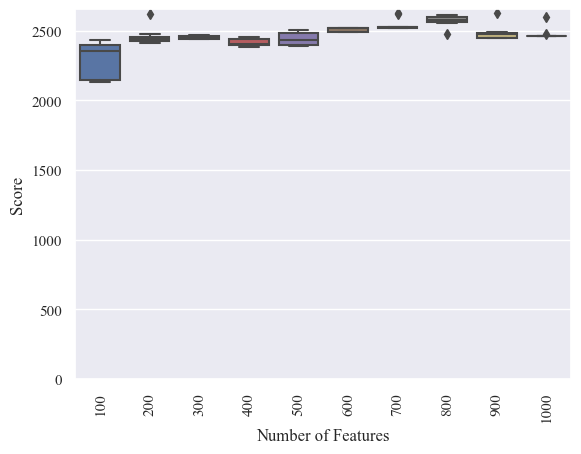

In [20]:
# df1 = pd.DataFrame()
number_of_features_experiments = list()
for i in range(100, 600, 100):
    fibers, y_true = experiment(number_of_features=i, set_number_of_bins=i)
    try:
        tdf = fibers.get_bin_scores().drop(['Bin #'], axis=1).head(10)
        tdf['param'] = i
        df1 = df1.append(tdf)
    except:
        print("Failed with param ", i)
    save_plots(fibers, "number_of_features_var_bins", i, y_true)
    number_of_features_experiments.append(fibers)

df_list.append(df1)

In [21]:
save_box_plots(df1, "Number of Features", "number_of_features_var_bins_2")

In [22]:
len(df_list)

5